In [8]:
%matplotlib inline
import random
import numpy as np
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import sys
from pathlib import Path

sys.path.insert(0, Path('').resolve().parent.parent.as_posix())
from utils import dl_utils

c:\Users\voidwu\anaconda3\envs\d2l\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# 线性回归数据集

In [2]:
def synthetic_data(w, b, num_examples):
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [3]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

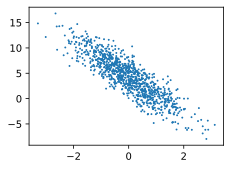

In [4]:
dl_utils.set_figsize()
dl_utils.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

In [5]:
# scratch 实现
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i : min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]


# pytorch 实现
def load_array(data_arrays, batch_size, is_train=True):  # @save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)


batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [6]:
next(iter(data_iter))

[tensor([[-0.9952,  0.0247],
         [-0.7921, -1.0730],
         [-0.6640,  0.0446],
         [ 0.7257,  1.3088],
         [-0.1246,  0.0630],
         [ 0.6742,  0.0864],
         [-0.7495, -0.0731],
         [-0.2369,  0.0787],
         [ 1.0325, -0.6550],
         [-0.0337,  2.5183]]),
 tensor([[ 2.1251],
         [ 6.2522],
         [ 2.7158],
         [ 1.2152],
         [ 3.7285],
         [ 5.2579],
         [ 2.9462],
         [ 3.4493],
         [ 8.4934],
         [-4.4347]])]

# Fashion-Mnist数据集

In [9]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)

In [11]:
len(mnist_train), len(mnist_test), mnist_train[0][0].shape

(60000, 10000, torch.Size([1, 28, 28]))

In [12]:
# Fashion-MNIST中包含的10个类别，分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。

def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ["t-shirt", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]
    return [text_labels[int(i)] for i in labels]

array([<Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 't-shirt'}>], dtype=object)

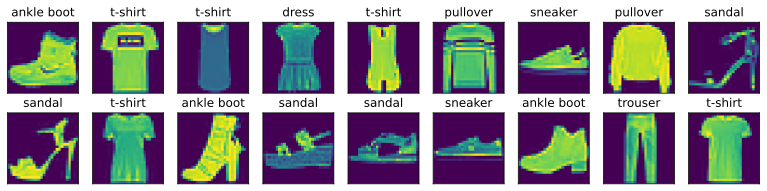

In [13]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
dl_utils.show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

In [ ]:
# 整合组件
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)
    return (
        data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=dl_utils.get_dataloader_workers()),
        data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=dl_utils.get_dataloader_workers()),
    )


train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break